# Train 1D CNN

1D Convolution을 기본 구성 요소로 하는 EEG classifier를 학습해보는 노트북.

- Three-way SoftMax classifier of normal, non-vascular MCI, and non-vascular dementia

-----

## 환경 구성

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load some packages
import os
import time
import glob
import json
import datetime

import matplotlib.pyplot as plt
import pprint
from IPython.display import clear_output
from tqdm.auto import tqdm

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from typing import Type, Any, Callable, Union, List, Optional

# custom package
from utils.eeg_dataset import *

In [3]:
# Other settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # cleaner text

plt.style.use('default') 
# ['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 
#  'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 
#  'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 
#  'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 
#  'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams["font.family"] = 'NanumGothic' # for Hangul in Windows

In [4]:
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.')

PyTorch version: 1.9.0
cuda is available.


In [5]:
# Data file path
root_path = r'dataset/02_Curated_Data/'

In [6]:
meta_path = os.path.join(root_path, 'metadata_debug.json')
with open(meta_path, 'r') as json_file:
    metadata = json.load(json_file)

pprint.pprint(metadata[0])

{'age': 78,
 'birth': '1940-06-02',
 'dx1': 'mci_rf',
 'edfname': '00001809_261018',
 'events': [[0, 'Start Recording'],
            [0, 'New Montage - Montage 002'],
            [36396, 'Eyes Open'],
            [72518, 'Eyes Closed'],
            [73862, 'Eyes Open'],
            [75248, 'Eyes Closed'],
            [76728, 'swallowing'],
            [77978, 'Eyes Open'],
            [79406, 'Eyes Closed'],
            [79996, 'Photic On - 3.0 Hz'],
            [80288, 'Eyes Open'],
            [81296, 'Eyes Closed'],
            [82054, 'Photic Off'],
            [84070, 'Photic On - 6.0 Hz'],
            [84488, 'Eyes Open'],
            [85538, 'Eyes Closed'],
            [86086, 'Photic Off'],
            [88144, 'Photic On - 9.0 Hz'],
            [90160, 'Photic Off'],
            [91458, 'Eyes Open'],
            [92218, 'Photic On - 12.0 Hz'],
            [92762, 'Eyes Closed'],
            [94198, 'Photic Off'],
            [94742, 'Eyes Open'],
            [95708, 'Eyes Close

-----

## Data Filtering by Diagnosis

#### Non-Vascular Dementia, Non-Vascular MCI, Normal

In [7]:
diagnosis_filter = [
    # Normal
    {'type': 'Normal',
     'include': ['normal'], 
     'exclude': []},
    # Non-vascular MCI
    {'type': 'Non-vascular MCI',
     'include': ['mci'], 
     'exclude': ['mci_vascular']},
    # Non-vascular dementia
    {'type': 'Non-vascular dementia',
     'include': ['dementia'], 
     'exclude': ['vd']},
]

def generate_class_label(label):
    for c, f in enumerate(diagnosis_filter):
        inc = set(f['include']) & set(label) == set(f['include'])
        # inc = len(set(f['include']) & set(label)) > 0        
        exc = len(set(f['exclude']) & set(label)) == 0
        if  inc and exc:
            return (c, f['type'])
    return (-1, 'The others')

class_label_to_type = [d_f['type'] for d_f in diagnosis_filter]
print('class_label_to_type:', class_label_to_type)

class_label_to_type: ['Normal', 'Non-vascular MCI', 'Non-vascular dementia']


In [8]:
splitted_metadata = [[] for i in diagnosis_filter]

for m in metadata:
    c, n = generate_class_label(m['label'])
    if c >= 0:
        m['class_type'] = n
        m['class_label'] = c
        splitted_metadata[c].append(m)
        
for i, split in enumerate(splitted_metadata):
    if len(split) == 0:
        print(f'(Warning) Split group {i} has no data.')
    else:
        print(f'- There are {len(split):} data belonging to {split[0]["class_type"]}')

- There are 463 data belonging to Normal
- There are 347 data belonging to Non-vascular MCI
- There are 229 data belonging to Non-vascular dementia


In [9]:
# random seed
random.seed(0)

# Train : Val : Test = 8 : 1 : 1
ratio1 = 0.8
ratio2 = 0.1

metadata_train_splitted = []
metadata_train = []
metadata_val = []
metadata_test = []

for split in splitted_metadata:
    random.shuffle(split)
    
    n1 = round(len(split) * ratio1)
    n2 = n1 + round(len(split) * ratio2)
    
    metadata_train_splitted.append(split[:n1])
    metadata_train.extend(split[:n1])
    metadata_val.extend(split[n1:n2])
    metadata_test.extend(split[n2:])

random.shuffle(metadata_train)
random.shuffle(metadata_val)
random.shuffle(metadata_test)

print('Train data size\t\t:', len(metadata_train))
print('Validation data size\t:', len(metadata_val))
print('Test data size\t\t:', len(metadata_test))

print('\n', '--- Recheck ---', '\n')
train_class_nums = np.zeros((len(class_label_to_type)), dtype=np.int32)
for m in metadata_train:
    train_class_nums[m['class_label']] += 1

val_class_nums = np.zeros((len(class_label_to_type)), dtype=np.int32)
for m in metadata_val:
    val_class_nums[m['class_label']] += 1

test_class_nums = np.zeros((len(class_label_to_type)), dtype=np.int32)
for m in metadata_test:
    test_class_nums[m['class_label']] += 1

print('Train data label distribution\t:', train_class_nums, train_class_nums.sum())
print('Val data label distribution\t:', val_class_nums, val_class_nums.sum())
print('Test data label distribution\t:', test_class_nums, test_class_nums.sum())

# random seed
random.seed()

# print([m['serial']  for m in metadata_train[:15]])
# print([m['serial']  for m in metadata_val[:15]])
# print([m['serial']  for m in metadata_test[:15]])

Train data size		: 831
Validation data size	: 104
Test data size		: 104

 --- Recheck --- 

Train data label distribution	: [370 278 183] 831
Val data label distribution	: [46 35 23] 104
Test data label distribution	: [47 34 23] 104


-----

## Configure the Train, Validation, and Test Splits

#### Split the filtered dataset and shuffle them

#### Wrap the splitted data using PyTorch Dataset

In [10]:
ages = []
for m in metadata_train:
    ages.append(m['age'])

ages = np.array(ages)
age_mean = np.mean(ages)
age_std = np.std(ages)

print('Age mean and standard deviation:')
print(age_mean, age_std)

Age mean and standard deviation:
69.92779783393502 9.817569889945597


In [11]:
composed = transforms.Compose([EEGNormalizeAge(mean=age_mean, std=age_std),
                               EEGDropPhoticChannel(),
                               EEGRandomCrop(crop_length=200*10), # 10 sec
                               EEGNormalizePerSignal(),
                               EEGToTensor()])

train_dataset = EEGDataset(root_path, metadata_train, composed)
val_dataset = EEGDataset(root_path, metadata_val, composed)
test_dataset = EEGDataset(root_path, metadata_test, composed)

print(train_dataset[0]['signal'].shape)
print(train_dataset[0])

print()
print('-' * 100)
print()

print(val_dataset[0]['signal'].shape)
print(val_dataset[0])

print()
print('-' * 100)
print()

print(test_dataset[0]['signal'].shape)
print(test_dataset[0])

torch.Size([20, 2000])
{'signal': tensor([[ 0.1755,  0.1206,  0.0931,  ..., -0.8125, -0.7851, -0.6753],
        [ 0.0924, -0.0803, -0.0803,  ..., -0.7135, -0.7135, -0.6560],
        [ 1.0355,  1.0355,  1.1136,  ...,  1.5821,  1.5040,  1.5040],
        ...,
        [-0.0111, -0.0111, -0.0111,  ..., -1.0149, -1.1582, -1.3016],
        [-1.0105, -0.8122, -0.6139,  ...,  0.4768,  0.6750,  0.4768],
        [ 1.0202,  0.8748,  0.8748,  ...,  0.5563,  0.4247,  0.3624]]), 'age': tensor(-1.2149), 'class_label': tensor(0), 'metadata': {'serial': '01012', 'edfname': '01212635_270515', 'birth': '1956-06-01', 'record': '2015-05-27T09:37:24', 'age': 58, 'dx1': 'cb_normal', 'label': ['normal', 'cb_normal'], 'events': [[0, 'Start Recording'], [0, 'New Montage - Montage 002'], [400, 'Eyes Open'], [7918, 'Eyes Closed'], [14091, 'Eyes Open'], [18208, 'Eyes Closed'], [24256, 'Eyes Open'], [30724, 'Eyes Closed'], [36562, 'Eyes Open'], [42190, 'Eyes Closed'], [48910, 'Eyes Open'], [55126, 'Eyes Closed'], [6

#### Data loader test

In [12]:
print('Current PyTorch device:', device)
if device.type == 'cuda':
    num_workers = 0 # A number other than 0 causes an error
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = DataLoader(train_dataset, 
                          batch_size=32, 
                          shuffle=True, 
                          drop_last=True,
                          num_workers=num_workers, 
                          pin_memory=pin_memory,
                          collate_fn=eeg_collate_fn)

for i_batch, sample_batched in enumerate(train_loader):
    sample_batched['signal'].to(device)
    sample_batched['age'].to(device)
    sample_batched['class_label'].to(device)
    
    print(i_batch, 
          sample_batched['signal'].shape, 
          sample_batched['age'].shape, 
          sample_batched['class_label'].shape, 
          len(sample_batched['metadata']))
    
    if i_batch > 3:
        break

Current PyTorch device: cuda
0 torch.Size([32, 20, 2000]) torch.Size([32]) torch.Size([32]) 32
1 torch.Size([32, 20, 2000]) torch.Size([32]) torch.Size([32]) 32
2 torch.Size([32, 20, 2000]) torch.Size([32]) torch.Size([32]) 32
3 torch.Size([32, 20, 2000]) torch.Size([32]) torch.Size([32]) 32
4 torch.Size([32, 20, 2000]) torch.Size([32]) torch.Size([32]) 32


#### Train, validation, test dataloaders

In [13]:
train_loader = DataLoader(train_dataset, 
                          batch_size=32, 
                          shuffle=True, 
                          drop_last=True,
                          num_workers=num_workers, 
                          pin_memory=pin_memory,
                          collate_fn=eeg_collate_fn)

val_loader = DataLoader(val_dataset, 
                        batch_size=32, 
                        shuffle=False, 
                        drop_last=False,
                        num_workers=num_workers, 
                        pin_memory=pin_memory,
                        collate_fn=eeg_collate_fn)

test_loader = DataLoader(test_dataset, 
                         batch_size=32, 
                         shuffle=False, 
                         drop_last=False,
                         num_workers=num_workers, 
                         pin_memory=pin_memory,
                         collate_fn=eeg_collate_fn)

-----

## Some useful functions for training

In [14]:
from torch.utils.tensorboard import SummaryWriter
import ipynbname
nb_fname = ipynbname.name()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def visualize_network_tensorboard(model, name):
    # default `log_dir` is "runs" - we'll be more specific here
    writer = SummaryWriter('runs/' + nb_fname + '_' + name)

    for batch_i, sample_batched in enumerate(train_loader):
        # pull up the batch data
        x = sample_batched['signal'].to(device)
        age = sample_batched['age'].to(device)
        target = sample_batched['class_label'].to(device)

        # apply model on whole batch directly on device
        writer.add_graph(model, (x, age))
        output = model(x, age, print_shape=True)
        break
        
    writer.close()

In [15]:
def check_val_accuracy(model, repeat=1):
    model.eval()
    
    correct, total = (0, 0)
    C = len(class_label_to_type)
    val_confusion = np.zeros((C, C), dtype=np.int32)
    
    with torch.no_grad():
        for k in range(repeat):
            for sample_batched in val_loader:
                # pull up the data
                x = sample_batched['signal'].to(device)
                age = sample_batched['age'].to(device)
                target = sample_batched['class_label'].to(device)

                # apply model on whole batch directly on device
                output = model(x, age)
                pred = F.log_softmax(output, dim=1)

                # val accuracy
                pred = pred.argmax(dim=-1)
                correct += pred.squeeze().eq(target).sum().item()
                total += pred.shape[0]

                # confusion matrix
                val_confusion += calculate_confusion_matrix(pred, target)
            
    val_accuracy = 100.0 * correct / total
    return (val_accuracy, val_confusion)

    
def check_test_accuracy(model, repeat=1):
    model.eval()
    
    # for test accuracy
    correct, total = (0, 0) 
    
    # for confusion matrix
    C = len(class_label_to_type)
    test_confusion = np.zeros((C, C), dtype=np.int32)
    
    # for test debug
    test_debug = {data['metadata']['serial']: 
                  {'GT': data['class_label'].item(), 
                   'Acc': 0, 
                   'Pred': [0] * C} for data in test_dataset}
    
    # for ROC curve
    score = None
    target = None
    
    with torch.no_grad():
        for k in range(repeat):
            for sample_batched in test_loader:
                # pull up the data
                x = sample_batched['signal'].to(device)
                age = sample_batched['age'].to(device)
                y = sample_batched['class_label'].to(device)

                # apply model on whole batch directly on device
                output = model(x, age)
                s = F.softmax(output, dim=1)
                pred = F.log_softmax(output, dim=1)

                # test accuracy
                pred = pred.argmax(dim=-1)
                correct += pred.squeeze().eq(y).sum().item()
                total += pred.shape[0]

                if score is None:
                    score = s.detach().cpu().numpy()
                    target = y.detach().cpu().numpy()
                else:
                    score = np.concatenate((score, s.detach().cpu().numpy()), axis=0)
                    target = np.concatenate((target, y.detach().cpu().numpy()), axis=0)

                # confusion matrix
                test_confusion += calculate_confusion_matrix(pred, y)

                # test debug
                for n in range(pred.shape[0]):
                    serial = sample_batched['metadata'][n]['serial']
                    test_debug[serial]['edfname'] = sample_batched['metadata'][n]['edfname']
                    test_debug[serial]['Pred'][pred[n].item()] += 1
                    acc = test_debug[serial]['Pred'][y[n].item()] / np.sum(test_debug[serial]['Pred']) * 100
                    test_debug[serial]['Acc'] = f'{acc:>6.02f}%'
        
    test_accuracy = 100.0 * correct / total
    return (test_accuracy, test_confusion, test_debug, score, target)


def calculate_confusion_matrix(pred, target):
    N = target.shape[0]
    C = len(class_label_to_type)
    confusion = np.zeros((C, C), dtype=np.int32)
    
    for i in range(N):
        r = target[i]
        c = pred[i]
        confusion[r, c] += 1
    return confusion

In [16]:
def draw_loss_plot(loss_history):
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic
    
    fig = plt.figure(num=1, clear=True, figsize=(15.0, 6.0), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(loss_history)
    
    ax.vlines(0, 0, 1, transform=ax.get_xaxis_transform(), colors='k', alpha=0.1)    
    for e in range(1, n_epoch + 1):
        
        if e % lr_schedule_step == 0:
            ax.vlines(e*len(train_loader) - 1, 0, 1, transform=ax.get_xaxis_transform(), colors='m', alpha=0.3)
        else:
            ax.vlines(e*len(train_loader) - 1, 0, 1, transform=ax.get_xaxis_transform(), colors='k', alpha=0.1)
    
    ax.set_title('Loss Plot')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Training Loss')
    
    plt.show()
    fig.clear()
    plt.close(fig)


def draw_accuracy_history(train_acc_history, val_acc_history):
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic
    
    fig = plt.figure(num=1, clear=True, figsize=(15.0, 6.0), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(train_acc_history, 'r-', label='Train accuracy')
    ax.plot(val_acc_history, 'b-', label='Validation accuracy')
    ax.legend(loc='lower right')
    
    ax.set_title('Accuracy Plot during Training')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    
    plt.show()
    fig.clear()
    plt.close(fig)


def draw_confusion(confusion):
    C = len(class_label_to_type)
    
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic
    plt.rcParams['image.cmap'] = 'jet' # 'nipy_spectral'

    fig = plt.figure(num=1, clear=True, figsize=(5.0, 5.0), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(confusion, alpha=0.8)

    ax.set_xticks(np.arange(C))
    ax.set_yticks(np.arange(C))
    ax.set_xticklabels(class_label_to_type)
    ax.set_yticklabels(class_label_to_type)
    
    for r in range(C):
        for c in range(C):
            text = ax.text(c, r, confusion[r, c],
                           ha="center", va="center", color='k')
    
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Ground Truth')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    plt.show()
    fig.clear()
    plt.close(fig)

In [17]:
def learning_rate_search(model, min_log_lr, max_log_lr, trials, epochs):
    learning_rate_record = []
    for t in tqdm(range(trials)):
        log_lr = np.random.uniform(min_log_lr, max_log_lr)
        lr = 10 ** log_lr
        
        model.reset_weights()
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0001)

        for e in range(epochs):
            _, train_accuracy, _ = train_one_epoch(model, optimizer, log_interval=None)
        
        # Train accuracy for the final epoch is stored
        learning_rate_record.append((log_lr, train_accuracy))
    
    return learning_rate_record


def draw_learning_rate_record(learning_rate_record):
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic

    fig = plt.figure(num=1, clear=True, figsize=(8.0, 8.0), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1)
    
    ax.set_title('Learning Rate Search')
    ax.set_xlabel('Learning rate in log-scale')
    ax.set_ylabel('Train accuracy')
    
    for log_lr, val_accuracy in learning_rate_record:
        ax.scatter(log_lr, val_accuracy, c='r',
                   alpha=0.5, edgecolors='none')
    
    plt.show()
    fig.clear()
    plt.close(fig)

-----

## Define 1D CNN models

#### 1D CNN: Tiny model

In [18]:
class TinyNet(nn.Module):
    def __init__(self, n_input=20, n_output=3, stride=7, n_channel=64, 
                 use_age=True, final_pool='average'):
        super().__init__()
        
        if final_pool not in {'average', 'max'}:
            raise ValueError("final_pool must be set to one of ['average', 'max']")
        
        self.use_age = use_age
        
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=35, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=7)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(2)
        
        if final_pool == 'average':
            self.final_pool = nn.AdaptiveAvgPool1d(1)
        elif final_pool == 'max':
            self.final_pool = nn.AdaptiveMaxPool1d(1)
        
        if self.use_age:        
            self.fc1 = nn.Linear(n_channel + 1, n_channel)
        else:
            self.fc1 = nn.Linear(n_channel, n_channel)
            
        self.dropout = nn.Dropout(p=0.3)
        self.bnfc1 = nn.BatchNorm1d(n_channel)
        self.fc2 = nn.Linear(n_channel, n_output)
        
    def reset_weights(self):
        for m in self.modules():
            if hasattr(m, 'reset_parameters'):
                m.reset_parameters()

    def forward(self, x, age, print_shape=False):
        # conv-bn-relu-pool 
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)

        if print_shape:
            print('Shape right before squeezing:', x.shape)

        x = self.final_pool(x).squeeze()
        if self.use_age:
            x = torch.cat((x, age.reshape(-1, 1)), dim=1)

        # fc-bn-dropout-relu-fc
        x = self.fc1(x)
        x = self.bnfc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x
        # return F.log_softmax(x, dim=1)

In [19]:
model = TinyNet(n_input=train_dataset[0]['signal'].shape[0], 
                n_output=3, 
                use_age=True, 
                final_pool='max')

model = model.to(device, dtype=torch.float32)
print(model)
print()

# tensorboard visualization
visualize_network_tensorboard(model, 'TinyNet')

# number of parameters
n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

TinyNet(
  (conv1): Conv1d(20, 64, kernel_size=(35,), stride=(7,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(7,), stride=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (final_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=65, out_features=64, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (bnfc1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)



C:\Users\IPIS-Minjae\anaconda3\envs\EEG_Project\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Shape right before squeezing: torch.Size([32, 64, 32])
The Number of parameters of the model: 78,403


#### 1D CNN: M5-like model

In [20]:
class M5(nn.Module):
    def __init__(self, n_input=20, n_output=3, stride=4, n_channel=256, 
                 use_age=True, final_pool='average'):
        super().__init__()
        
        if final_pool not in {'average', 'max'}:
            raise ValueError("final_pool must be set to one of ['average', 'max']")
        
        self.use_age = use_age
        
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=41, stride=2)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(2)
        
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=11)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(2)
        
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=11)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(2)
        
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=11)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(2)
        
        self.conv5 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=11)
        self.bn5 = nn.BatchNorm1d(2 * n_channel)
        self.pool5 = nn.MaxPool1d(2)
        
        if final_pool == 'average':
            self.final_pool = nn.AdaptiveAvgPool1d(1)
        elif final_pool == 'max':
            self.final_pool = nn.AdaptiveMaxPool1d(1)
    
        if self.use_age:        
            self.fc1 = nn.Linear(2 * n_channel + 1, 2 * n_channel)
        else:
            self.fc1 = nn.Linear(2 * n_channel, 2 * n_channel)
            
        self.dropout = nn.Dropout(p=0.3)
        self.bnfc1 = nn.BatchNorm1d(2 * n_channel)
        self.fc2 = nn.Linear(2 * n_channel, n_output)
        
    def reset_weights(self):
        for m in self.modules():
            if hasattr(m, 'reset_parameters'):
                m.reset_parameters()

    def forward(self, x, age, print_shape=False):
        # conv-bn-relu-pool 
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)

        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)

        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.pool5(x)

        if print_shape:
            print('Shape right before squeezing:', x.shape)
    
        x = self.final_pool(x).squeeze()
        if self.use_age:
            x = torch.cat((x, age.reshape(-1, 1)), dim=1)

        # fc-bn-dropout-relu-fc
        x = self.fc1(x)
        x = self.bnfc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x
        # return F.log_softmax(x, dim=1)

In [21]:
model = M5(n_input=train_dataset[0]['signal'].shape[0], 
           n_output=3, 
           use_age=True, 
           final_pool='max')

model = model.to(device, dtype=torch.float32)
print(model)
print()

# tensorboard visualization
visualize_network_tensorboard(model, 'M5-like')

# number of parameters
n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

M5(
  (conv1): Conv1d(20, 256, kernel_size=(41,), stride=(2,))
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(256, 256, kernel_size=(11,), stride=(1,))
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(256, 512, kernel_size=(11,), stride=(1,))
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(512, 512, kernel_size=(11,), stride=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv1d(512, 512, kernel_size=(11,), stride

#### 1D CNN: ResNet-like model

In [22]:
class BasicResBlock(nn.Module):
    expansion: int = 1

    def __init__(self, c_in, c_out, kernel_size, stride) -> None:
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=c_in, out_channels=c_out, 
                               kernel_size=kernel_size, stride=stride, 
                               padding=kernel_size//2, bias=False)
        self.bn1 = nn.BatchNorm1d(c_out)

        self.conv2 = nn.Conv1d(in_channels=c_out, out_channels=c_out, 
                               kernel_size=kernel_size, stride=1, 
                               padding=kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm1d(c_out)

        self.relu = nn.ReLU(inplace=True)
        
        self.downsample = None
        if stride != 1 or c_in != c_out:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels=c_in, out_channels=c_out, 
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(c_out)
            )
                    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        if self.downsample is not None:
            identity = self.downsample(identity)
        x = self.relu(x + identity)
        
        return x

In [23]:
class BottleneckBlock(nn.Module):
    expansion: int = 4
        
    def __init__(self, c_in, c_out, kernel_size, stride) -> None:
        super().__init__()
        width = c_out
        self.conv1 = nn.Conv1d(in_channels=c_in, out_channels=width, 
                               kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm1d(width)

        self.conv2 = nn.Conv1d(in_channels=width, out_channels=width, 
                               kernel_size=kernel_size, stride=stride, 
                               padding=kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm1d(width)

        self.conv3 = nn.Conv1d(in_channels=width, out_channels=c_out*self.expansion, 
                               kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm1d(c_out*self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.downsample = None
        if stride != 1 or c_in != c_out*self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels=c_in, out_channels=c_out*self.expansion, 
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(c_out*self.expansion)
            )
                    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        if self.downsample is not None:
            identity = self.downsample(identity)
            
        x = self.relu(x + identity)
        
        return x

In [24]:
class ResNet(nn.Module):
    def __init__(self, 
                 block: Type[Union[BasicResBlock, BottleneckBlock]], 
                 conv_layers: List[int],
                 n_fc: int,
                 n_input=20,
                 n_output=3,
                 n_start=64,
                 kernel_size=9, 
                 use_age=True, 
                 final_pool='average') -> None:
        
        super().__init__()
        
        if final_pool not in {'average', 'max'}:
            raise ValueError("final_pool must be set to one of ['average', 'max']")        

        self.c_current = n_start
        self.use_age = use_age
        
        self.input_stage = nn.Sequential(
            nn.Conv1d(in_channels=n_input, out_channels=n_start, 
                      kernel_size=kernel_size*3, stride=2,
                      padding=(kernel_size*3)//2, bias=False),
            nn.BatchNorm1d(n_start), 
            nn.ReLU(),
        )
        
        self.conv_stage1 = self._make_conv_layer(block, conv_layers[0], n_start, kernel_size, stride=3)
        self.conv_stage2 = self._make_conv_layer(block, conv_layers[1], n_start*2, kernel_size, stride=3)
        self.conv_stage3 = self._make_conv_layer(block, conv_layers[2], n_start*4, kernel_size, stride=3)
        self.conv_stage4 = self._make_conv_layer(block, conv_layers[3], n_start*8, kernel_size, stride=3)
        
        if final_pool == 'average':
            self.final_pool = nn.AdaptiveAvgPool1d(1)
        elif final_pool == 'max':
            self.final_pool = nn.AdaptiveMaxPool1d(1)
        
        fc_layers = []        
        if self.use_age:
            self.c_current = self.c_current + 1
        
        for l in range(n_fc):
            layer = nn.Sequential(nn.Linear(self.c_current, self.c_current // 2, bias=False),
                                  nn.Dropout(p=0.1),
                                  nn.BatchNorm1d(self.c_current // 2), 
                                  nn.ReLU())
            self.c_current = self.c_current // 2
            fc_layers.append(layer)
        fc_layers.append(nn.Linear(self.c_current, n_output))
        self.fc_stage = nn.Sequential(*fc_layers)
        
    def reset_weights(self):
        for m in self.modules():
            if hasattr(m, 'reset_parameters'):
                m.reset_parameters()
        
    def _make_conv_layer(self, block: Type[Union[BasicResBlock, BottleneckBlock]], 
                         n_block: int, c_out: int, kernel_size: int, stride: int = 1) -> nn.Sequential:
        layers = []
        c_in = self.c_current
        layers.append(block(c_in, c_out, kernel_size, stride=1))

        c_in = c_out * block.expansion
        self.c_current = c_in
        for _ in range(1, n_block):
            layers.append(block(c_in, c_out, kernel_size, stride=1))
            
        layers.append(nn.MaxPool1d(kernel_size=stride))
            
        return nn.Sequential(*layers)

    def forward(self, x, age, print_shape=False):
        x = self.input_stage(x)
        
        x = self.conv_stage1(x)
        x = self.conv_stage2(x)
        x = self.conv_stage3(x)
        x = self.conv_stage4(x)

        if print_shape:
            print('Shape right before squeezing:', x.shape)
                
        x = self.final_pool(x).squeeze()
        if self.use_age:
            x = torch.cat((x, age.reshape(-1, 1)), dim=1)
        x = self.fc_stage(x)
        
        return x
        # return F.log_softmax(x, dim=2)

In [25]:
model = ResNet(block=BottleneckBlock, 
               conv_layers=[2, 2, 2, 2], 
               n_fc=3, 
               n_input=train_dataset[0]['signal'].shape[0], 
               n_output=3, 
               n_start=64,
               kernel_size=9, 
               use_age=True, 
               final_pool='max')

model = model.to(device, dtype=torch.float32)
print(model)
print()

# tensorboard visualization
visualize_network_tensorboard(model, 'ResNet-like')

# number of parameters
n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

ResNet(
  (input_stage): Sequential(
    (0): Conv1d(20, 64, kernel_size=(27,), stride=(2,), padding=(13,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_stage1): Sequential(
    (0): BottleneckBlock(
      (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv1d(64, 256, kernel_size=(1,), stride=(1,), bias=False)
      (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv1d(64, 256, kernel_size=(1,), stride=(1,), bias=False)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=Tru

#### Small ResNet-like Model

In [26]:
model = ResNet(block=BasicResBlock, conv_layers=[1, 1, 1, 1], n_fc=3, 
               n_input=train_dataset[0]['signal'].shape[0], n_output=3, n_start=64,
               kernel_size=9, use_age=False)

model = model.to(device, dtype=torch.float32)
print(model)
print()

n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

ResNet(
  (input_stage): Sequential(
    (0): Conv1d(20, 64, kernel_size=(27,), stride=(2,), padding=(13,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_stage1): Sequential(
    (0): BasicResBlock(
      (conv1): Conv1d(64, 64, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_stage2): Sequential(
    (0): BasicResBlock(
      (conv1): Conv1d(64, 128, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

-----

## Train the defined networks

In [27]:
del model

In [28]:
def model_generator(index):
    model_dict = {}
    if index == 0:
        model_dict['lr'] = 1.16e-02
        model_dict['name'] = 'TinyCNN'
        model_dict['model'] = TinyNet(n_input=train_dataset[0]['signal'].shape[0], 
                                      n_output=3, use_age=True, final_pool='max')
    elif index == 1:
        model_dict['lr'] = 6.51e-04
        model_dict['name'] = 'M5'
        model_dict['model'] = M5(n_input=train_dataset[0]['signal'].shape[0], 
                                 n_output=3, use_age=True, final_pool='max')
    elif index == 2:
        model_dict['lr'] = 3.45e-03
        model_dict['name'] = 'ResNet'
        model_dict['model'] = ResNet(block=BottleneckBlock, conv_layers=[2, 2, 2, 2], 
                                     n_fc=3, n_input=train_dataset[0]['signal'].shape[0], 
                                     n_output=3, n_start=64,kernel_size=9, 
                                     use_age=True, final_pool='max')
    elif index == 3:
        model_dict['lr'] = 5.01e-03
        model_dict['name'] = 'TinyResNet'
        model_dict['model'] = ResNet(block=BasicResBlock, conv_layers=[1, 1, 1, 1], 
                                     n_fc=3, n_input=train_dataset[0]['signal'].shape[0], 
                                     n_output=3, n_start=64, kernel_size=9, use_age=False)
    
    model_dict['model'] = model_dict['model'].to(device, dtype=torch.float32)
    return model_dict

In [29]:
log_path = f'output/Training_set_size_experiments/'
os.makedirs(log_path, exist_ok=True)

n_models = 4
n_repeats = 5
n_iters = 12500
history_interval = 100
lr_schedule_step = 5000
n_ratio = 10 # 19

file_check = True
start_from = None # {'ratio': 0.8, 'model': 2, 'repeat': 7}
pbar = tqdm(total=n_models * n_repeats * n_iters * n_ratio)

for ratio in np.linspace(start=0.1, stop=1, num=n_ratio):
    if start_from is not None and ratio < start_from['ratio']: 
        pbar.update(n_models * n_iters * n_repeats)
        continue
    
    for m in range(n_models):
        if start_from is not None and ratio <= start_from['ratio'] and m < start_from['model']:
            pbar.update(n_iters * n_repeats)
            continue
        
        model_dict = model_generator(m)
        model = model_dict['model']
        base_lr = model_dict['lr']
        
        for r in range(n_repeats):
            if start_from is not None and ratio <= start_from['ratio'] and m <= start_from['model'] and r < start_from['repeat']:
                pbar.update(n_iters)
                continue
            
            if file_check:
                path = os.path.join(log_path, f'ratio_{ratio:.1f}_{model_dict["name"]}_r{r:02d}.json')
                if os.path.isfile(path):
                    with open(path, 'r') as json_file:
                        log_dict = json.load(json_file)
                        script = f'- ratio {ratio:.1f}, model {log_dict["model"]}, repeat {r}: '\
                                 f'train/test accuracy {log_dict["train_accuracy_history"][-1]} / {log_dict["test_accuracy"]} - file exists'
                        print(script)
                    pbar.update(n_iters)
                    continue
            
            metadata_train_temp = []
            for split in metadata_train_splitted:
                s = np.array(split)
                ind = np.random.choice(len(s), round(len(s) * ratio), replace=False)
                metadata_train_temp.extend(s[ind])

            train_dataset_temp = EEGDataset(root_path, metadata_train_temp, composed)
            train_loader_temp = DataLoader(train_dataset_temp, batch_size=32, 
                                           shuffle=True, drop_last=True, num_workers=num_workers, 
                                           pin_memory=pin_memory, collate_fn=eeg_collate_fn)
            
            model.reset_weights()
            model.train()
            optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=0.0001)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_schedule_step, gamma=0.1)

            current_iter = 0
            loss_history = []
            train_accuracy_history = []
            correct, total = (0, 0)
            
            while True:
                for sample_batched in train_loader_temp:
                    x = sample_batched['signal'].to(device)
                    age = sample_batched['age'].to(device)
                    target = sample_batched['class_label'].to(device)
                    
                    output = model(x, age)
                    pred = F.log_softmax(output, dim=1)
                    loss = F.nll_loss(pred, target)
                    
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                    scheduler.step()
                    
                    pred = pred.argmax(dim=-1)
                    correct += pred.squeeze().eq(target).sum().item()
                    total += pred.shape[0]
                    
                    current_iter += 1
                    pbar.update(1)
                    
                    if current_iter % history_interval == 0:
                        loss_history.append(loss.item())
                        train_accuracy_history.append(100.0 * correct / total)                    
                        correct, total = (0, 0)
                        
                    if current_iter >= n_iters:
                        break            
                    
                if current_iter >= n_iters:
                    break     
            
            test_accuracy, test_confusion, test_debug = check_test_accuracy(model, repeat=30)
            
            path = os.path.join(log_path, f'ratio_{ratio:.1f}_{model_dict["name"]}_r{r:02d}.json')
            with open(path, 'w') as json_file:
                log_dict = {}
                log_dict['train_set_size'] = len(train_dataset_temp)
                temp_arr = np.array([t["class_label"].numpy() for t in train_dataset_temp])
                log_dict['class_dist'] = f'{np.sum(temp_arr == 0)}:{np.sum(temp_arr == 1)}:{np.sum(temp_arr == 2)}'
                log_dict['starting_lr'] = f'{base_lr:.5e}'
                log_dict['final_lr'] = f'{optimizer.param_groups[-1]["lr"]:.5e}'
                log_dict['test_accuracy'] = test_accuracy
                log_dict['test_confusion'] = test_confusion.tolist()
                log_dict['test_debug'] = test_debug
                log_dict['model'] = model_dict['name']
                log_dict['edf_names'] = [t['metadata']['edfname'] for t in train_dataset_temp]                
                log_dict['loss_history'] = loss_history
                log_dict['train_accuracy_history'] = train_accuracy_history
                json.dump(log_dict, json_file, indent=4)
            
            script = f'- ratio {ratio:.1f}, model {model_dict["name"]}, repeat {r}: '\
            f'train/test accuracy {train_accuracy_history[-1]:.4f} / {test_accuracy:.4f}'
            print(script)
            time.sleep(60 * 3) # RESTING---------------------------------------------------------------------------
        print()
    print('-' * 100)

pbar.close()

  0%|          | 0/2500000 [00:00<?, ?it/s]

- ratio 0.1, model TinyCNN, repeat 0: train/test accuracy 99.40625 / 54.39102564102564 - file exists
- ratio 0.1, model TinyCNN, repeat 1: train/test accuracy 98.96875 / 52.62820512820513 - file exists
- ratio 0.1, model TinyCNN, repeat 2: train/test accuracy 99.40625 / 52.82051282051282 - file exists
- ratio 0.1, model TinyCNN, repeat 3: train/test accuracy 99.375 / 48.044871794871796 - file exists
- ratio 0.1, model TinyCNN, repeat 4: train/test accuracy 99.40625 / 48.3974358974359 - file exists

- ratio 0.1, model M5, repeat 0: train/test accuracy 99.96875 / 50.8974358974359 - file exists
- ratio 0.1, model M5, repeat 1: train/test accuracy 99.90625 / 59.583333333333336 - file exists
- ratio 0.1, model M5, repeat 2: train/test accuracy 99.9375 / 49.67948717948718 - file exists
- ratio 0.1, model M5, repeat 3: train/test accuracy 99.8125 / 51.25 - file exists
- ratio 0.1, model M5, repeat 4: train/test accuracy 99.9375 / 55.28846153846154 - file exists

- ratio 0.1, model ResNet, rep

-----

## Visualization

In [30]:
models = ['TinyCNN', 'M5', 'ResNet']
train_accuracies = {}
test_accuracies = {}

for m in models:
    train_accuracies[m] = np.zeros((n_ratio, n_repeats))
    test_accuracies[m] = np.zeros((n_ratio, n_repeats))
    
    for ratio in np.linspace(start=0.1, stop=1, num=n_ratio):
        for r in range(n_repeats):
            path = os.path.join(log_path, f'ratio_{ratio:.1f}_{m}_r{r:02d}.json')
            if os.path.isfile(path):
                with open(path, 'r') as json_file:
                    log_dict = json.load(json_file)
            else:
                print('ERROR - File does not exist:', path)
                break
                
            train_accuracies[m][round(ratio*10) - 1, r] = log_dict['train_accuracy_history'][-1]
            test_accuracies[m][round(ratio*10) - 1, r] = log_dict['test_accuracy']

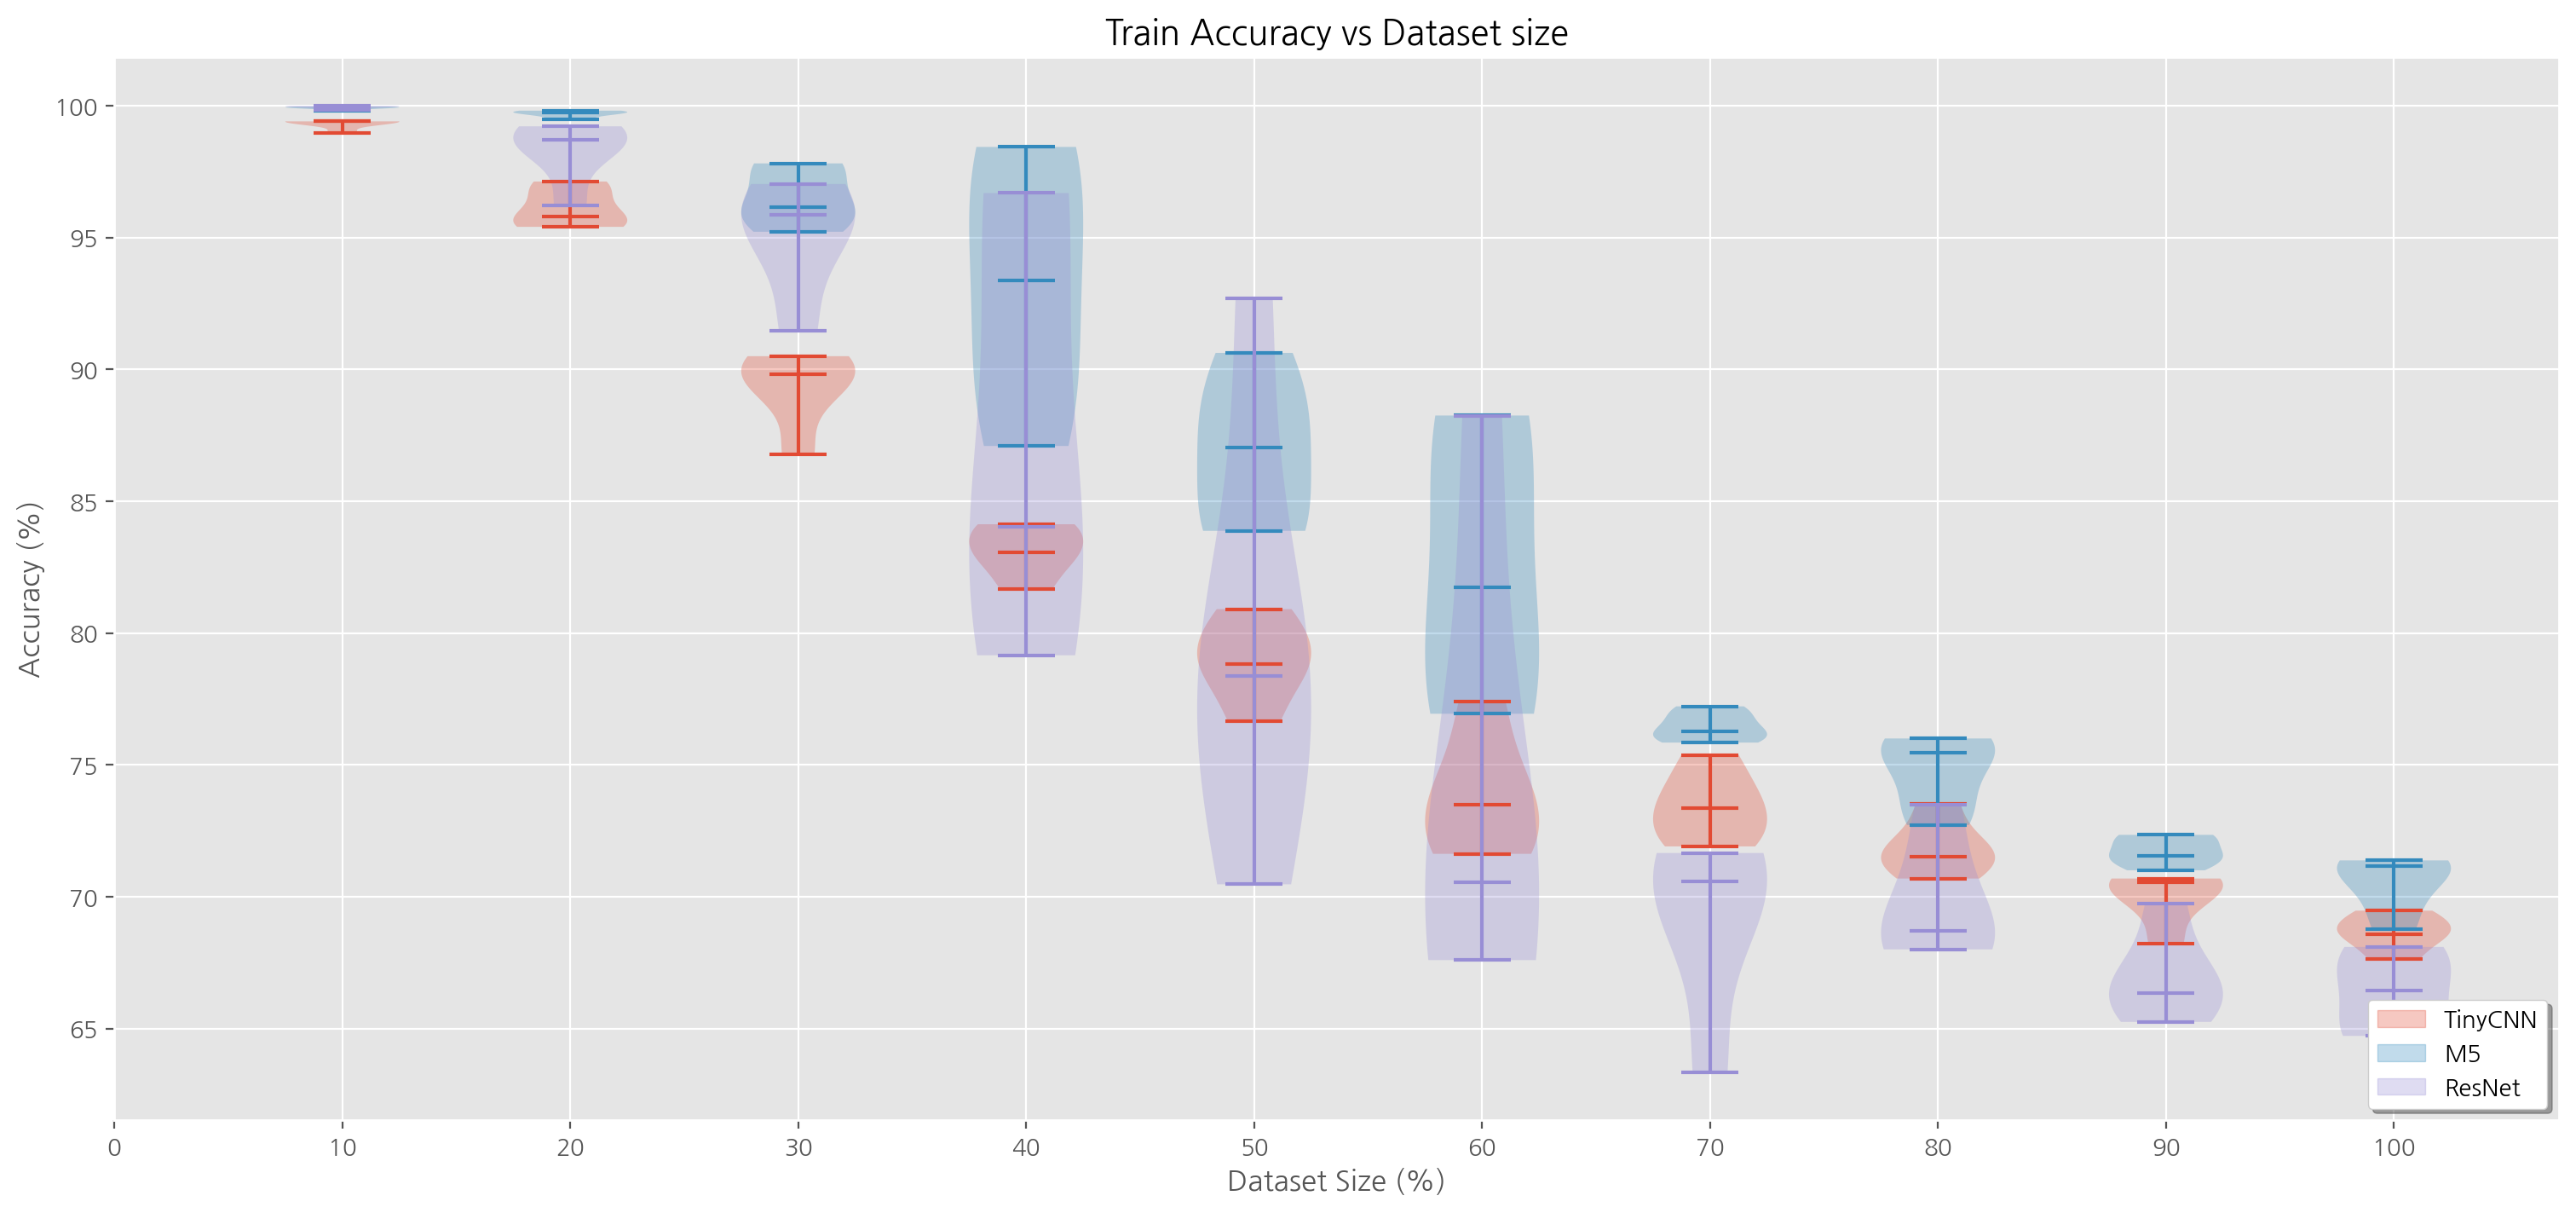

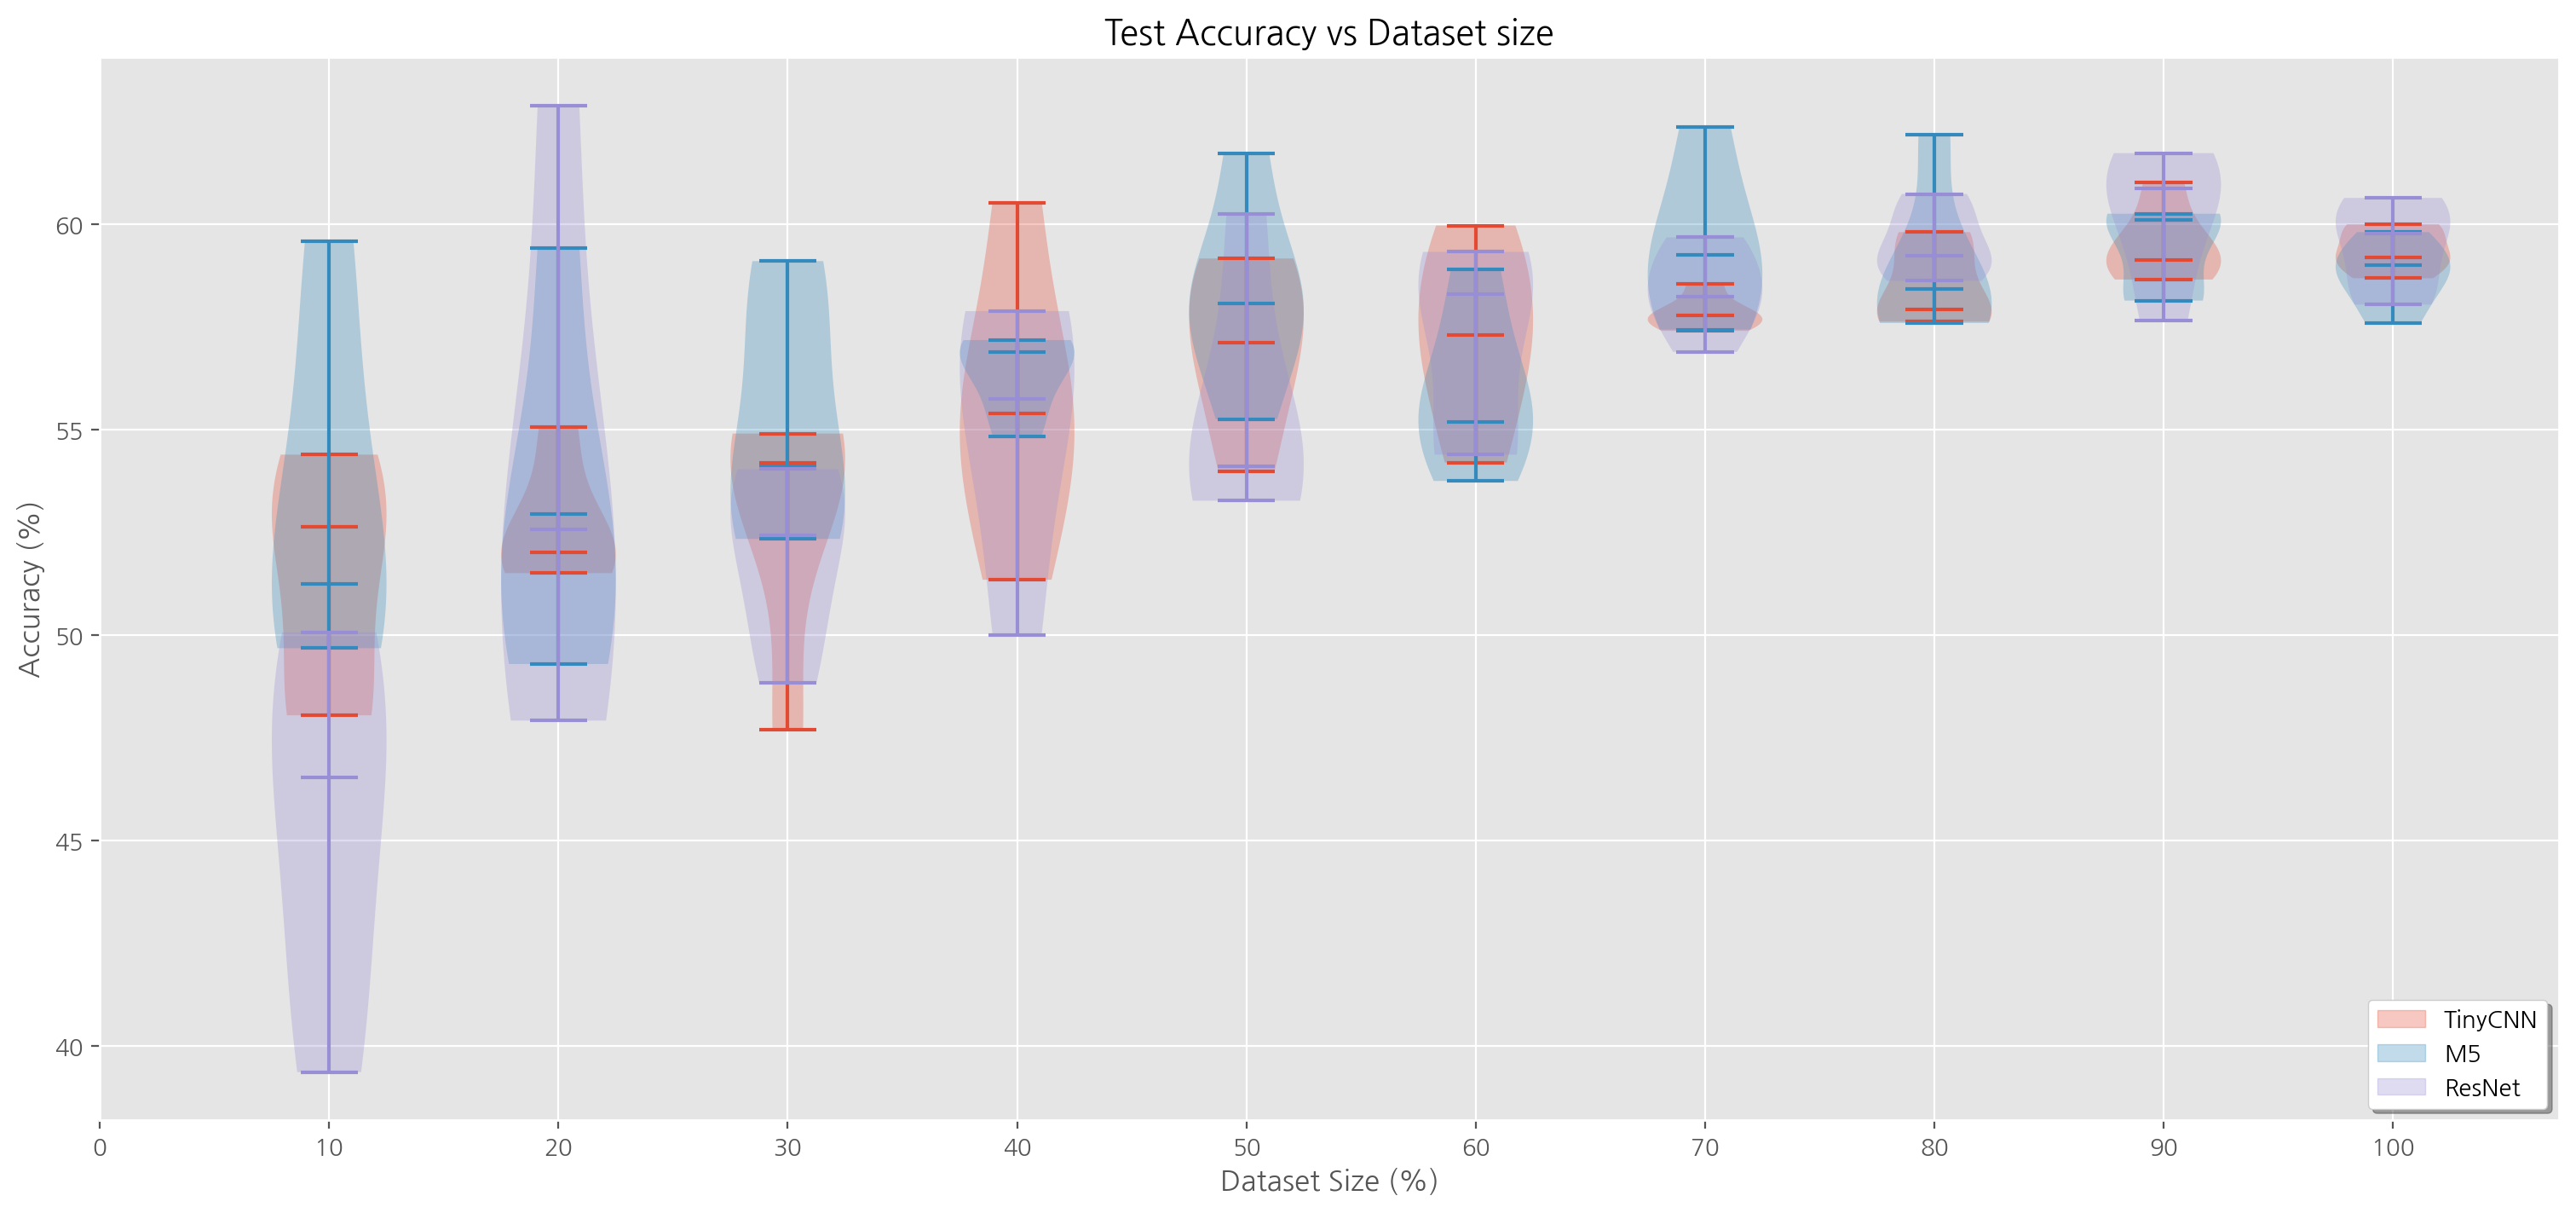

In [46]:
import matplotlib.patches as mpatches
plt.style.use('ggplot') # default, ggplot, fivethirtyeight, classic

fig = plt.figure(num=1, clear=True, figsize=(15.0, 7.0), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1)

labels = []
for i, m in enumerate(models):
    violin = ax.violinplot(train_accuracies[m].T, showmeans=False, showmedians=True)
    ax.yaxis.grid(True)
    
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), m))

ax.set_title('Train Accuracy vs Dataset size')
ax.set_xlabel('Dataset Size (%)')
ax.set_ylabel('Accuracy (%)')    
plt.setp(ax, xticks=[y for y in range(11)],
         xticklabels=np.arange(0, 101, 10))
plt.legend(*zip(*labels), loc='lower right', shadow=True).get_frame().set_facecolor('white')

plt.show()
fig.clear()
plt.close(fig)


fig = plt.figure(num=1, clear=True, figsize=(15.0, 7.0), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1)

labels = []
for i, m in enumerate(models):
    violin = ax.violinplot(test_accuracies[m].T, showmeans=False, showmedians=True)
    ax.yaxis.grid(True)
    
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), m))

ax.set_title('Test Accuracy vs Dataset size')
ax.set_xlabel('Dataset Size (%)')
ax.set_ylabel('Accuracy (%)')    
plt.setp(ax, xticks=[y for y in range(11)],
         xticklabels=np.arange(0, 101, 10))
plt.legend(*zip(*labels), loc='lower right', shadow=True).get_frame().set_facecolor('white')

plt.show()
fig.clear()
plt.close(fig)

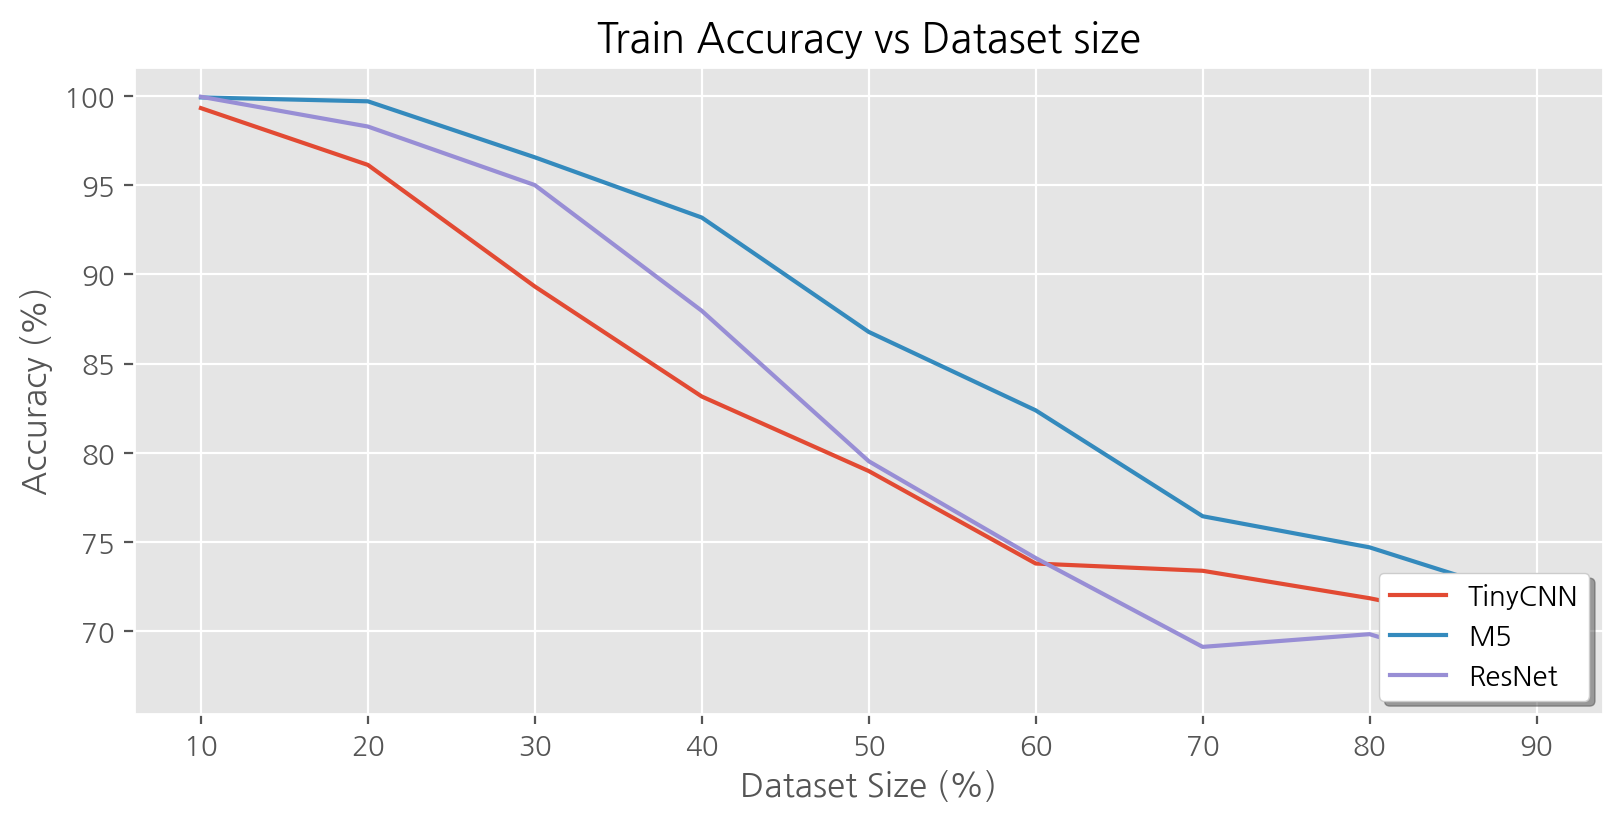

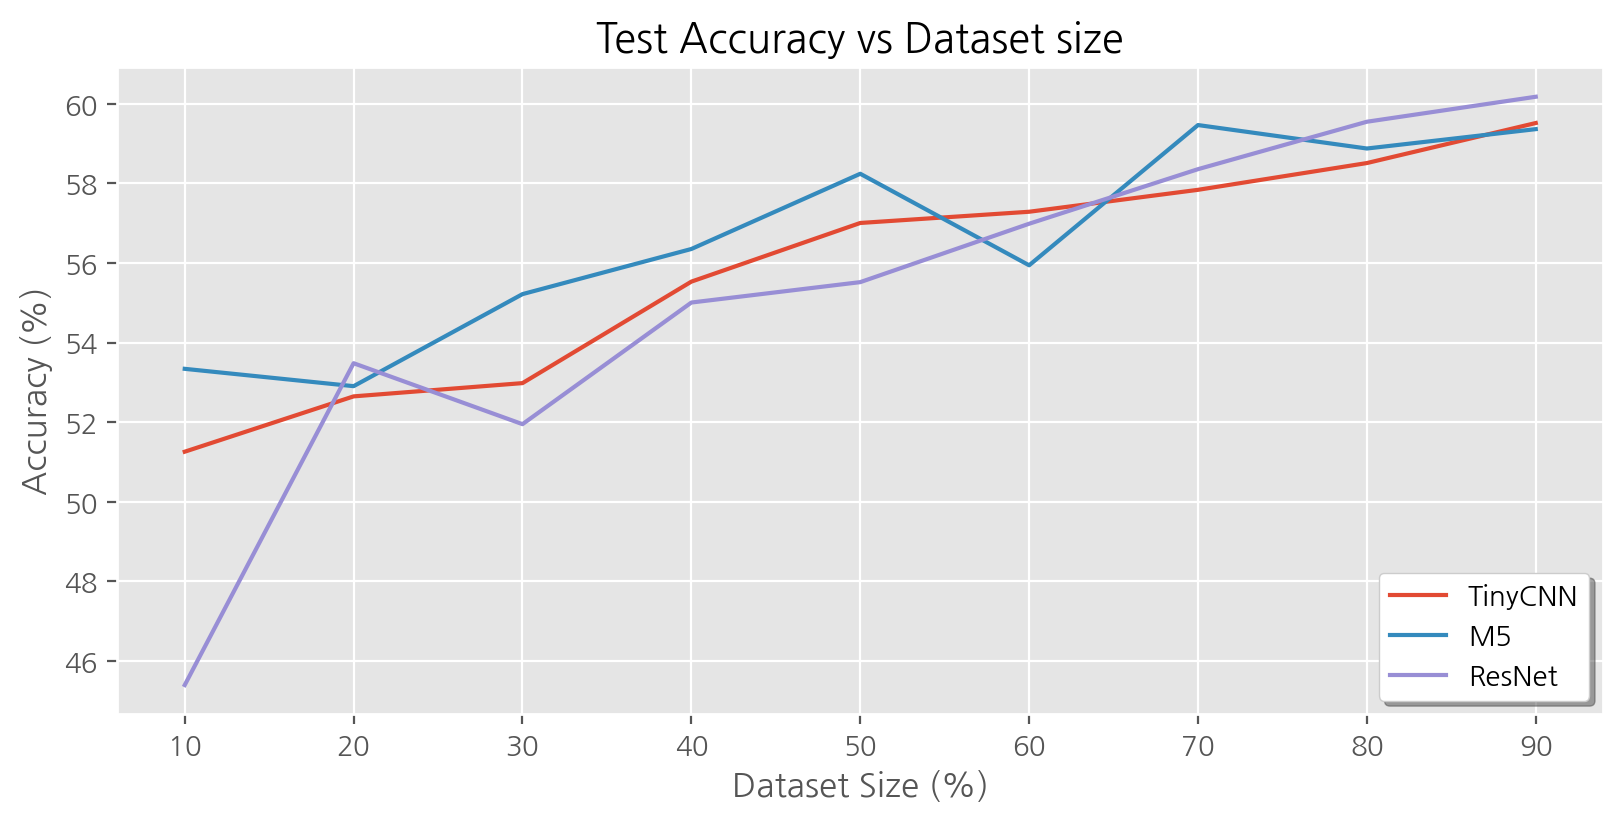

In [53]:
plt.style.use('ggplot') # default, ggplot, fivethirtyeight, classic

fig = plt.figure(num=1, clear=True, figsize=(8.0, 4.0), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1)

for i, m in enumerate(models):
    ax.plot(train_accuracies[m][:-1].mean(axis=1), label=m)
    
ax.set_title('Train Accuracy vs Dataset size')
ax.set_xlabel('Dataset Size (%)')
ax.set_ylabel('Accuracy (%)')    
plt.setp(ax, xticks=[y for y in range(9)],
         xticklabels=np.arange(10, 91, 10))
plt.legend(loc='lower right', shadow=True).get_frame().set_facecolor('white')

plt.show()
fig.clear()
plt.close(fig)


fig = plt.figure(num=1, clear=True, figsize=(8.0, 4.0), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1)

for i, m in enumerate(models):
    ax.plot(test_accuracies[m][:-1].mean(axis=1), label=m)

ax.set_title('Test Accuracy vs Dataset size')
ax.set_xlabel('Dataset Size (%)')
ax.set_ylabel('Accuracy (%)')    
plt.setp(ax, xticks=[y for y in range(9)],
         xticklabels=np.arange(10, 91, 10))
plt.legend(loc='lower right', shadow=True).get_frame().set_facecolor('white')

plt.show()
fig.clear()
plt.close(fig)

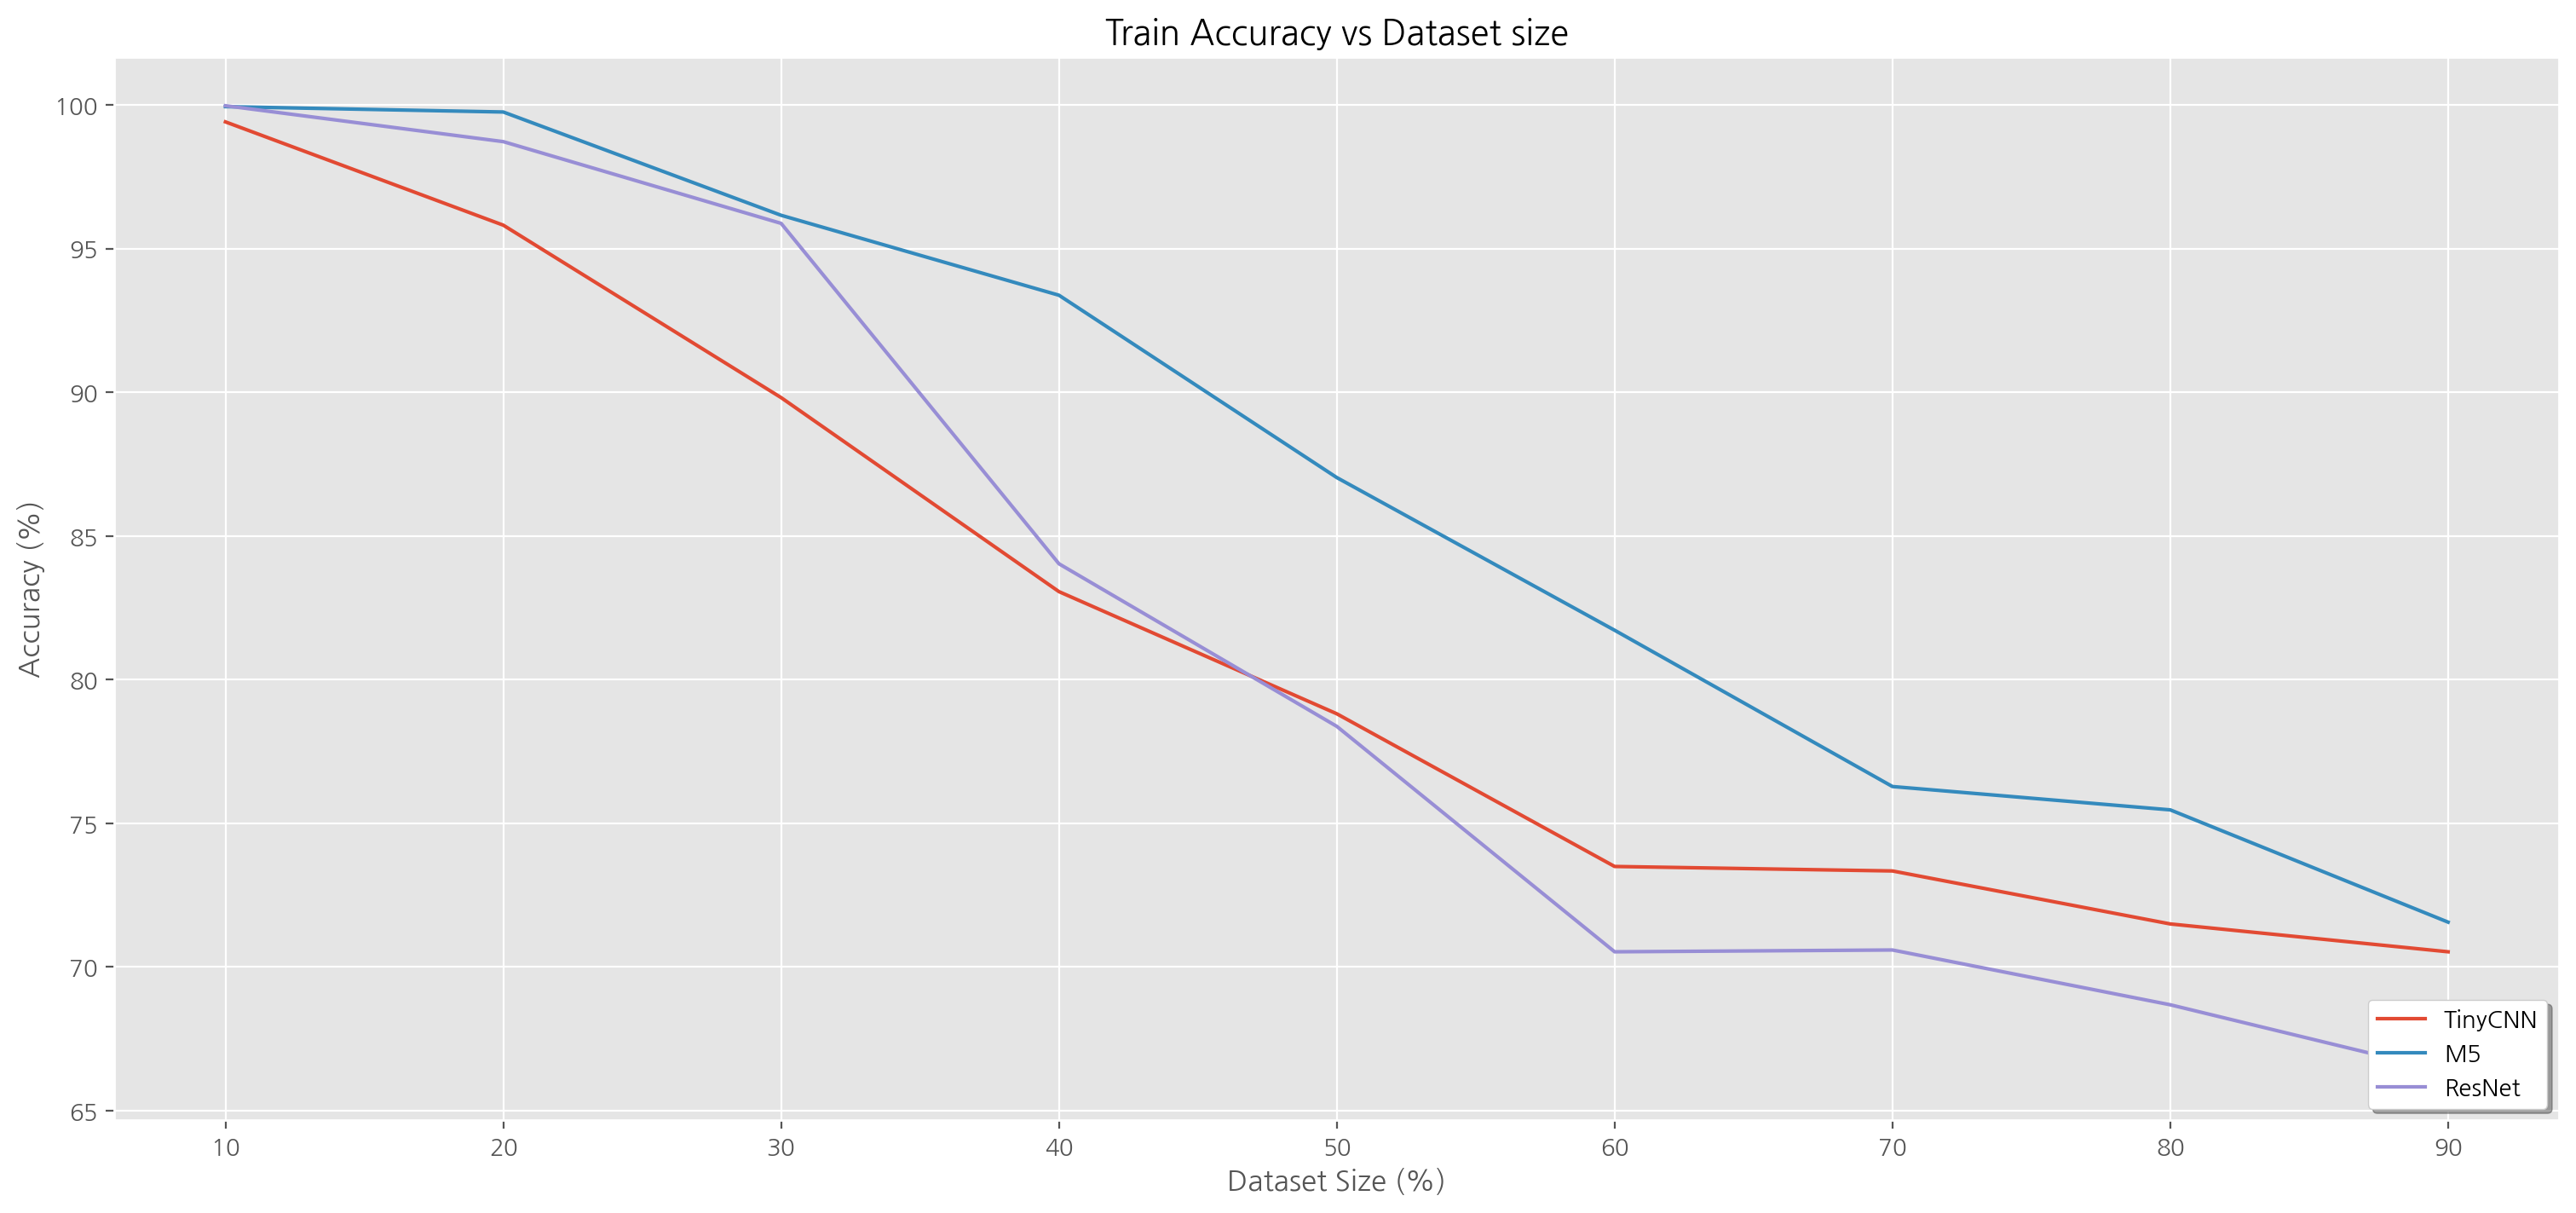

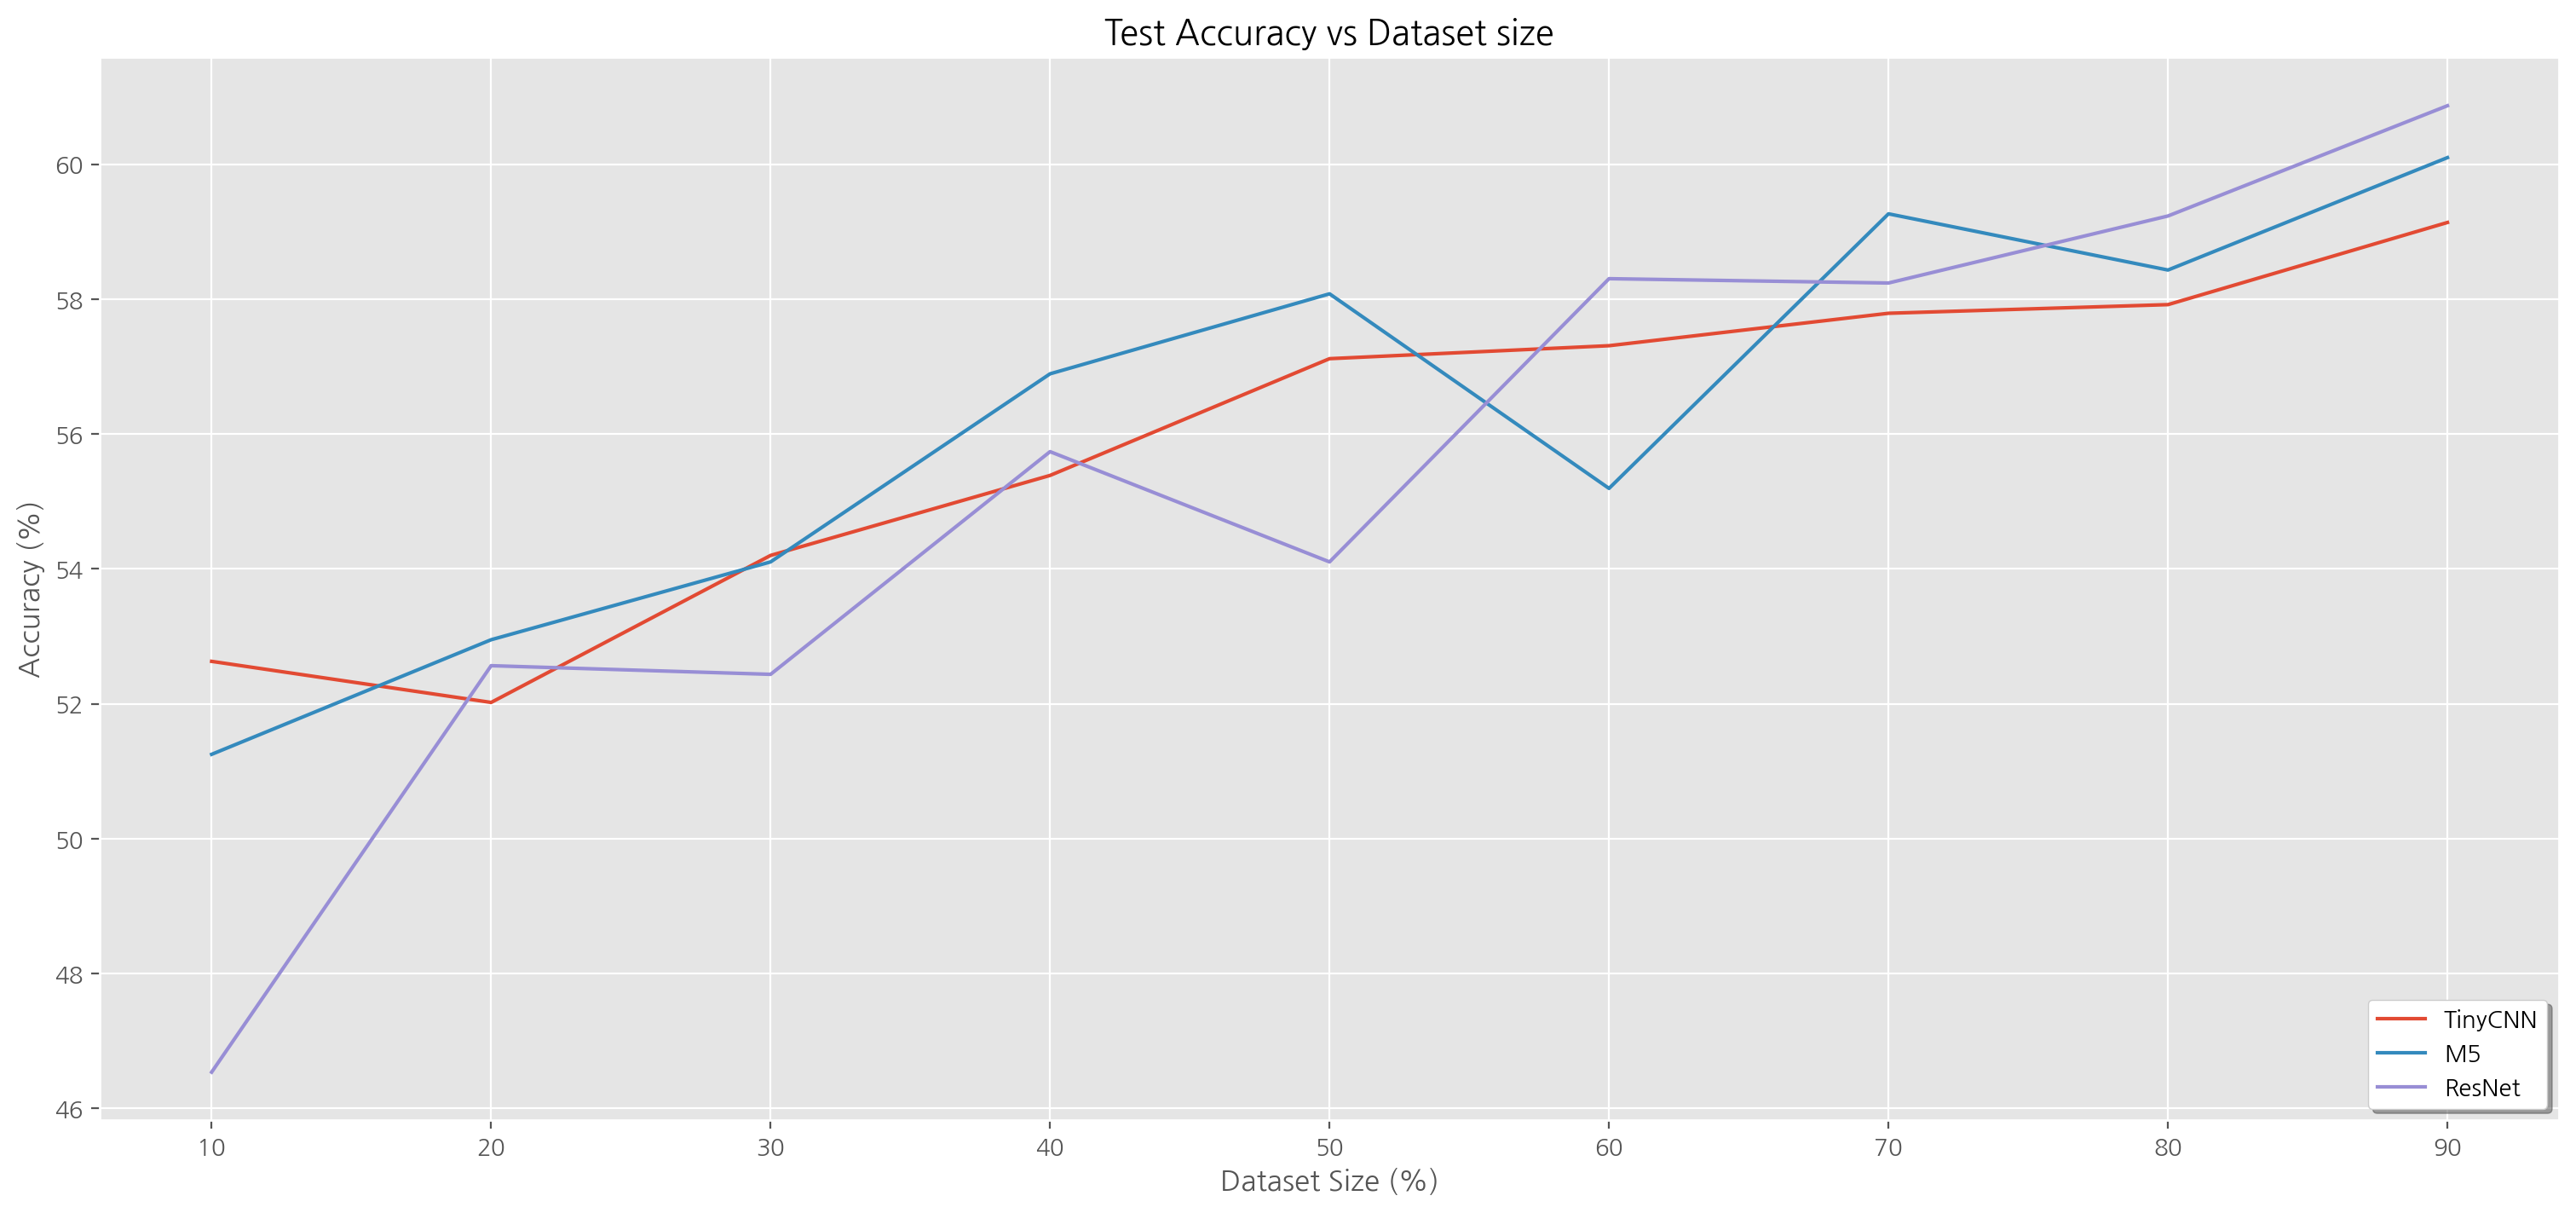

In [51]:
plt.style.use('ggplot') # default, ggplot, fivethirtyeight, classic

fig = plt.figure(num=1, clear=True, figsize=(15.0, 7.0), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1)

for i, m in enumerate(models):
    ax.plot(np.median(train_accuracies[m][:-1], axis=1), label=m)
    
ax.set_title('Train Accuracy vs Dataset size')
ax.set_xlabel('Dataset Size (%)')
ax.set_ylabel('Accuracy (%)')    
plt.setp(ax, xticks=[y for y in range(9)],
         xticklabels=np.arange(10, 91, 10))
plt.legend(loc='lower right', shadow=True).get_frame().set_facecolor('white')

plt.show()
fig.clear()
plt.close(fig)


fig = plt.figure(num=1, clear=True, figsize=(15.0, 7.0), constrained_layout=True)
ax = fig.add_subplot(1, 1, 1)

for i, m in enumerate(models):
    ax.plot(np.median(test_accuracies[m][:-1], axis=1), label=m)

ax.set_title('Test Accuracy vs Dataset size')
ax.set_xlabel('Dataset Size (%)')
ax.set_ylabel('Accuracy (%)')    
plt.setp(ax, xticks=[y for y in range(9)],
         xticklabels=np.arange(10, 91, 10))
plt.legend(loc='lower right', shadow=True).get_frame().set_facecolor('white')

plt.show()
fig.clear()
plt.close(fig)